#### **Import libraries and input file**

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Volve-Daily-Production-Data.csv to Volve-Daily-Production-Data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Volve-Daily-Production-Data.csv', thousands=',')
df = df[['DATEPRD','WELL_BORE_CODE','BORE_OIL_VOL']]
df = df.dropna(axis=0, how='any').reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9161 entries, 0 to 9160
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATEPRD         9161 non-null   object 
 1   WELL_BORE_CODE  9161 non-null   object 
 2   BORE_OIL_VOL    9161 non-null   float64
dtypes: float64(1), object(2)
memory usage: 214.8+ KB


In [3]:
df

,DATEPRD,WELL_BORE_CODE,BORE_OIL_VOL
0,07-Apr-14,NO 15/9-F-1 C,0.0
1,08-Apr-14,NO 15/9-F-1 C,0.0
2,09-Apr-14,NO 15/9-F-1 C,0.0
3,10-Apr-14,NO 15/9-F-1 C,0.0
4,11-Apr-14,NO 15/9-F-1 C,0.0
...,...,...,...
9156,13-Sep-16,NO 15/9-F-5 AH,0.0
9157,14-Sep-16,NO 15/9-F-5 AH,0.0
9158,15-Sep-16,NO 15/9-F-5 AH,0.0
9159,16-Sep-16,NO 15/9-F-5 AH,0.0


In [4]:
well_codes = df.WELL_BORE_CODE.unique()
well_codes

array(['NO 15/9-F-1 C', 'NO 15/9-F-11 H', 'NO 15/9-F-12 H',
       'NO 15/9-F-14 H', 'NO 15/9-F-15 D', 'NO 15/9-F-5 AH'], dtype=object)

In [5]:
numeric_day = 86400000000000

#### **Convert data dates into production days and plot**

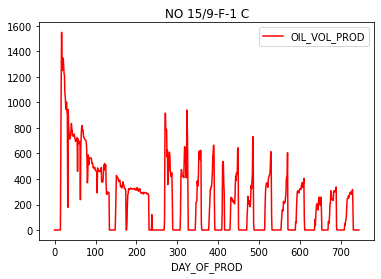

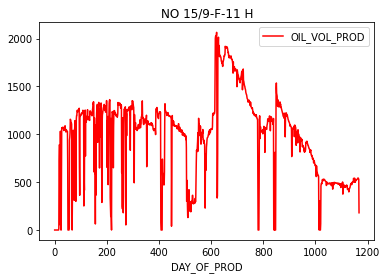

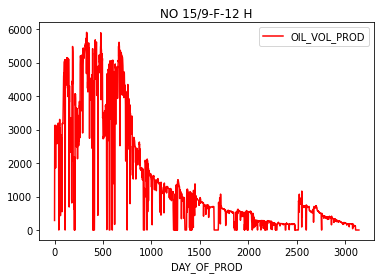

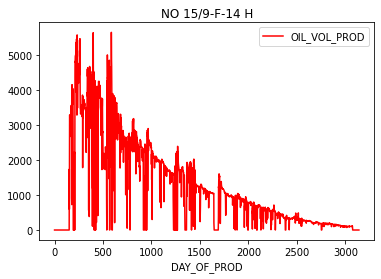

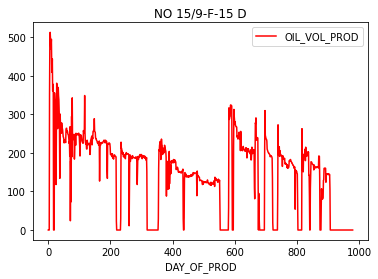

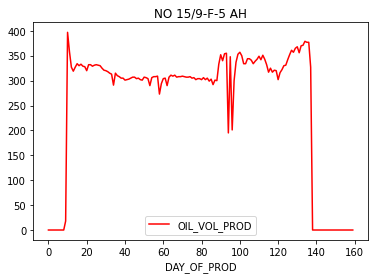

In [6]:
nwells = len(well_codes)
df_wells = []
for i in range(nwells):
    df_wells.append(df[df['WELL_BORE_CODE'] == well_codes[i]])
    df_wells[i] = df_wells[i].drop(columns=['WELL_BORE_CODE'])
    df_wells[i]['DATEPRD'] = pd.to_numeric(pd.to_datetime(df_wells[i]['DATEPRD']))
    df_wells[i]['DATEPRD'] = (df_wells[i]['DATEPRD'].values - \
                              df_wells[i]['DATEPRD'].values[0]) / numeric_day
    df_wells[i] = df_wells[i].rename(columns={'DATEPRD': 'DAY_OF_PROD', 
                                              'BORE_OIL_VOL': 'OIL_VOL_PROD'})
    df_wells[i].plot(x='DAY_OF_PROD', y='OIL_VOL_PROD',color='red')
    plt.title(well_codes[i])
    plt.show()

#### **Use data from wells** 
- 'NO 15/9-F-12 H' (Index: 2)
- 'NO 15/9-F-14 H' (Index: 3)

#### **to train LSTM models.**

#### **Ensure there are no gaps in data**

In [7]:
# Integrity check: Make sure there are no missing days 
# in the oil production data for these two wells.
for i in [2, 3]:
    days = df_wells[i]['DAY_OF_PROD'].values
    for j in range(1, len(days)):
        diff = days[j] - days[j-1]
        if(diff > 1):
            print(days[j-1])
            print(days[j])
            print('%d Missing day(s)' % (diff - 1))

75.0
77.0
1 Missing day(s)
176.0
178.0
1 Missing day(s)
447.0
449.0
1 Missing day(s)
537.0
539.0
1 Missing day(s)
566.0
568.0
1 Missing day(s)
746.0
749.0
2 Missing day(s)
753.0
755.0
1 Missing day(s)
915.0
917.0
1 Missing day(s)
917.0
920.0
2 Missing day(s)
923.0
925.0
1 Missing day(s)
1085.0
1089.0
3 Missing day(s)
1224.0
1228.0
3 Missing day(s)
1228.0
1232.0
3 Missing day(s)
1232.0
1235.0
2 Missing day(s)
1239.0
1241.0
1 Missing day(s)
1245.0
1247.0
1 Missing day(s)
1252.0
1254.0
1 Missing day(s)
1341.0
1345.0
3 Missing day(s)
1350.0
1352.0
1 Missing day(s)
1381.0
1385.0
3 Missing day(s)
1385.0
1389.0
3 Missing day(s)
1389.0
1392.0
2 Missing day(s)
1395.0
1397.0
1 Missing day(s)
1400.0
1402.0
1 Missing day(s)
1411.0
1413.0
1 Missing day(s)
1420.0
1432.0
11 Missing day(s)
1443.0
1445.0
1 Missing day(s)
1644.0
1646.0
1 Missing day(s)
1648.0
1650.0
1 Missing day(s)
1665.0
1669.0
3 Missing day(s)
1669.0
1673.0
3 Missing day(s)
1673.0
1677.0
3 Missing day(s)
1679.0
1681.0
1 Missing day(s

#### **Fill missing days with the last value**

In [8]:
well_names = []
day_of_prod = []
oil_vol_prod = []
cum_oil_prod = []
cum_prod = 0
for i in [2, 3]:
    well_code = well_codes[i]
    days = df_wells[i]['DAY_OF_PROD'].values
    vols = df_wells[i]['OIL_VOL_PROD'].values

    well_names.append(well_code)
    day_of_prod.append(days[0])
    oil_vol_prod.append(vols[0])
    cum_prod = vols[0]
    cum_oil_prod.append(cum_prod)
    for j in range(1, len(days)):
        diff = int(days[j] - days[j-1])
        if(diff > 1):
            for k in range(1,diff):
                well_names.append(well_code)
                day_of_prod.append(days[j-1] + k)
                oil_vol_prod.append(vols[j-1])
                cum_prod += vols[j-1]
                cum_oil_prod.append(cum_prod)
            well_names.append(well_code)
            day_of_prod.append(days[j])
            oil_vol_prod.append(vols[j])
            cum_prod += vols[j]
            cum_oil_prod.append(cum_prod)
        elif(diff==1):
            well_names.append(well_code)
            day_of_prod.append(days[j])
            oil_vol_prod.append(vols[j])
            cum_prod += vols[j]
            cum_oil_prod.append(cum_prod)   

#### **Repeat sanity check**

In [9]:
for j in range(1, len(day_of_prod)):
    diff = abs(int(day_of_prod[j] - day_of_prod[j-1]))
    if(diff > 1):
        print(day_of_prod[j-1])
        print(day_of_prod[j])
        print('%d Missing day(s)' % (diff - 1))

3140.0
0.0
3139 Missing day(s)


#### **Create merged dataframe, and write to file**

In [10]:
df_final = df = pd.DataFrame(list(zip(day_of_prod, oil_vol_prod, cum_oil_prod, well_names)), 
                             columns =['DAY_OF_PROD', 'OIL_PROD_VOL', 'CUM_OIL_PROD', 'WELL_CODE'])
df_final

,DAY_OF_PROD,OIL_PROD_VOL,CUM_OIL_PROD,WELL_CODE
0,0.0,285.0,285.0,NO 15/9-F-12 H
1,1.0,1870.0,2155.0,NO 15/9-F-12 H
2,2.0,3124.0,5279.0,NO 15/9-F-12 H
3,3.0,2608.0,7887.0,NO 15/9-F-12 H
4,4.0,3052.0,10939.0,NO 15/9-F-12 H
...,...,...,...,...
6277,3136.0,0.0,4007646.0,NO 15/9-F-14 H
6278,3137.0,0.0,4007646.0,NO 15/9-F-14 H
6279,3138.0,0.0,4007646.0,NO 15/9-F-14 H
6280,3139.0,0.0,4007646.0,NO 15/9-F-14 H


In [11]:
df_final.to_csv('Volve_Oil_Production.csv', index=False)